In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from decimal import Decimal
import Levenshtein 
from Levenshtein import distance, ratio
import nltk
from nltk.metrics import edit_distance, edit_distance_align
nltk.download('punkt_tab')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Le\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Расстояние Левинштейна с весами (по словам)

In [ ]:
def levinshtein_distance(t1, t2, insert=1, delete=1, change=1):
    if isinstance(t1, str):
        t1 = t1.split()
        t2 = t2.split()
    return distance(
                t1, 
                t2,
                weights=(
                    insert,      # вставка
                    delete,      # удаление
                    change       # замена
                )
            )

levinshtein_distance(text1, text2)

### Нахождение индексов изменений (по Левинштейну)

In [3]:
def levenshtein_distance_positions(list1, list2, del_cost=1, ins_cost=1, sub_cost=1):
    
    if isinstance(list1, str):
        list1 = list1.split()
        list2 = list2.split()
        
    len1, len2 = len(list1), len(list2)
    dp = [[0] * (len2 + 1) for _ in range(len1 + 1)]

    # Инициализация первой строки и столбца
    for i in range(1, len1 + 1):
        dp[i][0] = i * del_cost
    for j in range(1, len2 + 1):
        dp[0][j] = j * ins_cost

    # Заполнение таблицы
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            if list1[i - 1] == list2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]  # Без стоимости, если элементы совпадают
            else:
                dp[i][j] = min(
                    dp[i - 1][j] + del_cost,      # Удаление
                    dp[i][j - 1] + ins_cost,      # Вставка
                    dp[i - 1][j - 1] + sub_cost   # Замена
                )

    # Обратное восстановление пути
    i, j = len1, len2
    res_dict = {
        "distance": dp[len1][len2],
        "delete": [],
        "insert": [],
        "change": []
    }

    while i > 0 or j > 0:
        if i > 0 and j > 0 and list1[i - 1] == list2[j - 1]:
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i - 1][j] + del_cost:
            res_dict["delete"].append((i - 1,))
            i -= 1
        elif j > 0 and dp[i][j] == dp[i][j - 1] + ins_cost:
            res_dict["insert"].append((j - 1,))
            j -= 1
        elif i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + sub_cost:
            res_dict["change"].append((i - 1, j - 1))
            i -= 1
            j -= 1

    return res_dict

levenshtein_distance_positions(
    ["8", "1"],
    ["2", "1", "9"]
)

{'distance': 2, 'delete': [], 'insert': [(2,)], 'change': [(0, 0)]}

### Расстояние Левинштейна с перестановками (по словам)


In [4]:
edit_distance(["1", "2"], ["2", "1"], substitution_cost=1, transpositions=True)

1

### Нормализованное на длину текстов расстояние Левинштейна

In [6]:
def levinshtein_distance_norm(t1, t2, insert=1, delete=1, change=1):
    if isinstance(t1, str):
        t1 = t1.split()
        t2 = t2.split()
    return distance(
                t1, 
                t2,
                weights=(
                    insert,      # вставка
                    delete,      # удаление
                    change       # замена
                )
            ) * 1.0 / (len(t1) + len(t2))

### Матрица близости текстов

In [7]:
def get_metrics_matrices(texts_list, distance_funcs, titles, axis_labels=None):
    num_plots = len(distance_funcs)
    rows = (num_plots + 2) // 3  # Определяем количество строк, по 3 графика в каждой строке
    cols = min(3, num_plots)     # Не более 3 графиков в строке
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))  # Настраиваем размер полотна
    axes = axes.flatten() if num_plots > 1 else [axes]  # Упрощаем доступ к осям

    matrices = []  # Список для хранения всех матриц расстояний

    # Используем числовые метки по умолчанию, если axis_labels не задан
    axis_labels = axis_labels if axis_labels is not None else [str(i + 1) for i in range(len(texts_list))]

    for idx, (distance_func, title) in enumerate(zip(distance_funcs, titles)):
        # Создаем и заполняем матрицу расстояний
        matrix = np.zeros((len(texts_list), len(texts_list)))
        for i in range(len(texts_list)):
            for j in range(len(texts_list)):
                matrix[i, j] = format(distance_func(texts_list[i], texts_list[j]), 'f')
                
        sns.heatmap(data=matrix, 
                    annot=True,
                    cmap="crest", 
                    ax=axes[idx],
                    xticklabels=axis_labels,
                    yticklabels=axis_labels)  # Устанавливаем пользовательские метки осей
        
        if title:
            axes[idx].set_title(title)
        
        matrices.append(matrix)  # Добавляем текущую матрицу в список

    # Отключаем оставшиеся пустые оси
    for ax in axes[num_plots:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return matrices

### Токенизация

In [9]:
from collections import defaultdict

def compute_pair_scores(splits, word_freqs):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

def merge_pair(a, b, splits, word_freqs):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

def encode_word(word, vocab):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

def fit_tokenizer(corpus, vocab_size):
    word_freqs = defaultdict(int)
    for text in corpus:
        if isinstance(text, str):
            text = text.split()
        for word in text:
            if word != '':  # вот тут осторожно - надо проверять аккуратнее такие кейсы
                word_freqs[word] += 1      
    
    alphabet = []
    for word in word_freqs.keys():
        if word[0] not in alphabet:
            alphabet.append(word[0])
        for letter in word[1:]:
            if f"##{letter}" not in alphabet:
                alphabet.append(f"##{letter}")
    alphabet.sort()
    
    vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()
    
    splits = {
        word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
        for word in word_freqs.keys()
    }
    
    pair_scores = compute_pair_scores(splits, word_freqs)
    for i, key in enumerate(pair_scores.keys()):
#         print(f"{key}: {pair_scores[key]}")
        if i >= 5:
            break
            
    best_pair = ""
    max_score = None
    for pair, score in pair_scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
#     print(best_pair, max_score)
    
    vocab_size = vocab_size
    while len(vocab) < vocab_size:
        scores = compute_pair_scores(splits, word_freqs)
        best_pair, max_score = "", None
        for pair, score in scores.items():
            if max_score is None or max_score < score:
                best_pair = pair
                max_score = score
        try:
            splits = merge_pair(*best_pair, splits, word_freqs)
        except:
            print('max vocab size exceeded')
            break
        new_token = (
            best_pair[0] + best_pair[1][2:]
            if best_pair[1].startswith("##")
            else best_pair[0] + best_pair[1]
        )
        vocab.append(new_token)
    print('vocab size: ', len(vocab))
    
    return vocab

def tokenize(text, vocab):
    if isinstance(text, str):
        text = text.split()
    encoded_words = [encode_word(word, vocab) for word in text]
    return sum(encoded_words, [])

### Работа со славянскими текстами

In [18]:
import docx

def getText(filename):
    
    superdict = {
        'K': [],
        'O': [],
        'Д': [],
        'I': [],
        'П': [],
        'В': [],
        'other': []
     }
    
    doc = docx.Document(filename)
    for para in doc.paragraphs:
        text = para.text
        if text[:2] == 'K\t':
            superdict['K'] += [text[2:]]
        elif text[:2] == 'O\t':
            superdict['O'] += [text[2:]]
        elif text[:2] == 'Д\t':
            superdict['Д'] += [text[2:]]
        elif text[:2] == 'I\t':
            superdict['I'] += [text[2:]]
        elif text[:2] == 'П\t':
            superdict['П'] += [text[2:]]
        elif text[:2] == 'В\t':
            superdict['В'] += [text[2:]]
        else:
            superdict['other'] += [text]
            
    return superdict

In [65]:
from PIL import Image, ImageDraw, ImageFont, ImageShow

def printText(text, canvas_w=1000, canvas_h=270, font_path="Bukyvede.ttf", font_size=25):
    
    font_path = font_path  
    font_size = font_size
    font = ImageFont.truetype(font_path, font_size)
    
    image = Image.new('RGB', (canvas_w, canvas_h), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)

    draw.text((10, 10), text, font=font, fill=(0, 0, 0))
    display(image)

    
def printTextWithColors(text_parts, canvas_w=1000, canvas_h=170, font_path="Bukyvede.ttf", font_size=25):
    """
    Отображает текст с раскрашенными частями.
    :param text_parts: Список кортежей (текст, цвет), где цвет в формате (R, G, B).
    :param canvas_w: Ширина холста.
    :param canvas_h: Высота холста.
    :param font_path: Путь к файлу шрифта.
    :param font_size: Размер шрифта.
    """
    font = ImageFont.truetype(font_path, font_size)
    image = Image.new('RGB', (canvas_w, canvas_h), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)
    
    x_offset = 10  # Начальная позиция текста по горизонтали
    y_offset = 10  # Начальная позиция текста по вертикали
    space = 15  # Расстояние между словами
    line_len_limit = canvas_w - 20  # Порог для переноса строки

    # Проходим по частям текста с их цветами
    for part_text, color in text_parts:
        text_width, text_height = draw.textsize(part_text, font=font)
        
        # Проверяем, поместится ли следующий текст в текущую строку
        if x_offset + text_width > line_len_limit:
            # Перенос на новую строку
            x_offset = 10
            y_offset += text_height + space  # Переход вниз на следующую строку
        
        # Рисуем текст
        draw.text((x_offset, y_offset), part_text, font=font, fill=color)
        
        # Обновляем смещение по X для следующей части текста
        x_offset += text_width + space

    display(image)

In [32]:
from termcolor import colored

def highlight_changes_slavic(text1, text2):
    
    changes = levenshtein_distance_positions(text1, text2)
    
    if isinstance(text1, str):
        text1 = text1.split()
        text2 = text2.split()
    
    highlighted_text1 = text1.copy()
    highlighted_text2 = text2.copy()
    for i, item in enumerate(highlighted_text1):
        highlighted_text1[i] = (item, (0,0,0))
    for i, item in enumerate(highlighted_text2):
        highlighted_text2[i] = (item, (0,0,0))


    # Помечаем удаленные слова (удалены из text1)
    for delete_index in changes['delete']:
        idx = delete_index[0]
        if 0 <= idx < len(highlighted_text1):
            highlighted_text1[idx] = (
                highlighted_text1[idx][0] + f"({idx})",
                (255, 0, 0)  # red
            )

    # Помечаем вставленные слова (вставлены в text2)
    for insert_index in changes['insert']:
        idx = insert_index[0]
        if 0 <= idx < len(highlighted_text2):
            highlighted_text2[idx] = (
                highlighted_text2[idx][0] + f"({idx})",
                (0, 255, 0)  # green
            )
            
    highlighted_text1_indexed = highlighted_text1.copy()
    highlighted_text2_indexed = highlighted_text2.copy()  
    
    # Помечаем измененные слова
    for change_pair in changes['change']:
        idx1, idx2 = change_pair
        if 0 <= idx1 < len(highlighted_text1):
            highlighted_text1_indexed[idx1] = highlighted_text1[idx1]
            highlighted_text1[idx1] = (
                highlighted_text1[idx1][0] + f"::{highlighted_text2[idx2][0]}",
                (200, 200, 0)  # yellow
            )
            
        if 0 <= idx2 < len(highlighted_text2):            
            highlighted_text2[idx2] = (
                highlighted_text2[idx2][0] + f"::{highlighted_text1_indexed[idx1][0]}",
                (200, 200, 0)  # yellow
            )

    # Возвращаем измененные тексты
    return highlighted_text1, highlighted_text2


In [111]:
def get_portion_of_unchanged_tokens(colored_text):
    s_black = 0
    s_all = 0
    for item in colored_text:
        
        tmp = 0
        if item[0] == "#" and len(item[0] >= 3):
            tmp = len(item[0])
        else:
            tmp = len(item[0]) - 2  # убираю решетки
            
        s_all += tmp 
            
        if item[1] == (0,0,0):
            s_black += tmp
    return round(s_black / s_all,2)

### Прогресс

Читаю вордовский док и смотрю на его структуру

In [33]:
doc = docx.Document('Сирах из Княж. Изборника.docx')

t = '\n'.join([x.text for x in doc.paragraphs[18:25]])
print(t)

<6:0> Wisdom of Jesus Son of Sirach (6:207–208 interpolated)
K	ⱂⱃⱑⰿⰴⱃⱁⱄⱅⱐ ⰻⰹⱄⱛⱄⱁⰲⰰ ⱄⱖⱀⰰ ⱄⰹⱃⰰⱈⱁⰲⰰ 
O	прѣмѫдрость іисоусова сꙑна сирахова 
Д	прмдрсть іс҃а сн҃а сирахова| 
I	прѣмѹдрость и҃сва| с҃на сирахова⁘| 
П	Прмдрсть іссва сн҃а сирахова| 
В	премꙋдрости ис҃ова с҃на| сирахѡва· глав кд҃| 


Шрифт не читается. Приходится использовать изображения

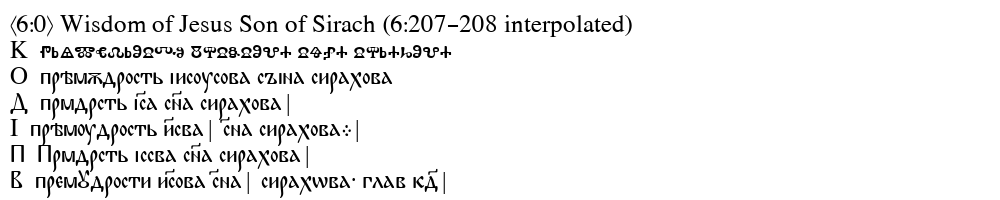

In [34]:
# Загрузка шрифта
font_path = "Bukyvede.ttf"  
font_size = 25
font = ImageFont.truetype(font_path, font_size)

# Создание изображения
image = Image.new('RGB', (1000, 200), color=(255, 255, 255))
draw = ImageDraw.Draw(image)
draw.text((10, 10), t.replace('\t', '  '), font=font, fill=(0, 0, 0))

display(image)

Хочу посмотреть на символы отдельно - в каждой строчке ставлю по +1 пробелу между символами

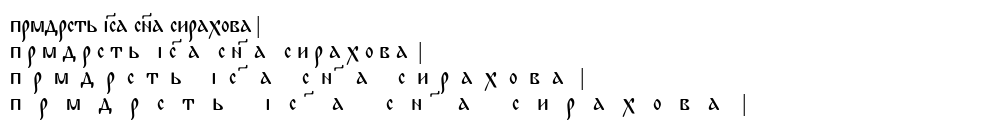

In [35]:
image = Image.new('RGB', (1000, 130), color=(255, 255, 255))
draw = ImageDraw.Draw(image)

text0 = doc.paragraphs[21].text[2:]
text = text0 + "\n" + ' '.join(text0) + "\n" + '  '.join(text0) + "\n" + '   '.join(text0)

draw.text((10, 10), text, font=font, fill=(0, 0, 0))
display(image)

Работа с файлом

In [36]:
import re
pattern = r"^<[^>]+:[^>]+>"

print(True if re.match(pattern, doc.paragraphs[18].text) else False)  # английская
print(doc.paragraphs[19].text[:2] == 'K\t')  # английская
print(doc.paragraphs[20].text[:2] == 'O\t')  # английская
print(doc.paragraphs[21].text[:2] == 'Д\t')  # русская
print(doc.paragraphs[22].text[:2] == 'I\t')  # английская
print(doc.paragraphs[23].text[:2] == 'П\t')  # русская
print(doc.paragraphs[24].text[:2] == 'В\t')  # русская

True
True
True
True
True
True
True


Выделяем отдельно каждый текст из файла

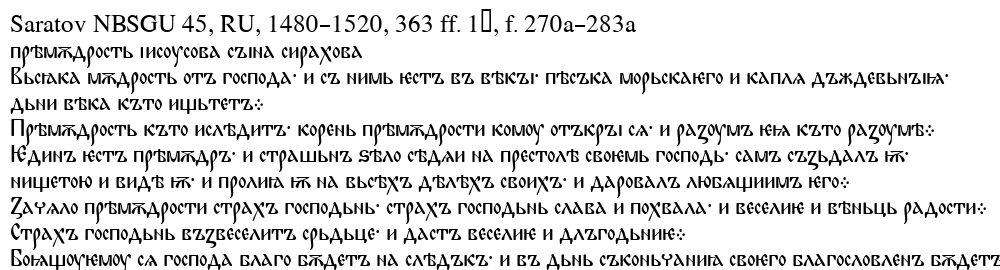

In [39]:
superdict = getText("Сирах из Княж. Изборника.docx")
printText('\n'.join(superdict['O'][:]))

Чтобы не возиться с большими текстами, для первого сравнения предлагаю выбрать 10 первых строк к каждого текста, склеить через пробел и разбить по словам. Получим датасет.  [не забыть, что первая строчка - это пояснение к источнику]

In [41]:
dataset = superdict.copy()

for key in dataset.keys():
    dataset[key] = ''.join(dataset[key][1:11])  # пропускаем первую строчку
    dataset[key] = dataset[key].split(' ')
    
print(dataset['O'])

['прѣмѫдрость', 'іисоусова', 'сꙑна', 'сирахова', 'Вьсꙗка', 'мѫдрость', 'отъ', 'господа·', 'и', 'съ', 'нимь', 'ѥстъ', 'въ', 'вѣкꙑ·', 'пѣсъка', 'морьскаѥго', 'и', 'каплѧ', 'дъждевьнꙑѩ·', 'дьни', 'вѣка', 'къто', 'ищьтетъ⁘', 'Прѣмѫдрость', 'къто', 'ислѣдитъ·', 'корень', 'прѣмѫдрости', 'комѹ', 'отъкрꙑ', 'сѧ·', 'и', 'раꙁѹмъ', 'ѥѩ', 'къто', 'раꙁѹмѣ⁘', 'Ѥдинъ', 'ѥстъ', 'прѣмѫдръ·', 'и', 'страшьнъ', 'ѕѣло', 'сѣдѧи', 'на', 'престолѣ', 'своѥмь', 'господь·', 'самъ', 'съꙁьдалъ', 'ѭ·', 'нищетою', 'и', 'видѣ', 'ѭ·', 'и', 'пролиꙗ', 'ѭ', 'на', 'вьсѣхъ', 'дѣлѣхъ', 'своихъ·', 'и', 'даровалъ', 'любѧщиимъ', 'ѥго⁘', 'Ꙁачѧло', 'прѣмѫдрости', 'страхъ', 'господьнь·', 'страхъ', 'господьнь', 'слава', 'и', 'похвала·', 'и', 'веселиѥ', 'и', 'вѣньць', 'радости⁘', 'Страхъ', 'господьнь', 'въꙁвеселитъ', 'срьдьце·', 'и', 'дастъ', 'веселиѥ', 'и', 'длъгодьниѥ⁘', 'Боѩщѹѥмѹ', 'сѧ', 'господа', 'благо', 'бѫдетъ', 'на', 'слѣдъкъ·', 'и', 'въ', 'дьнь', 'съконьчаниꙗ', 'своѥго', 'благословленъ', 'бѫдетъ⁘', 'Мъножьство', 'мѫдрости'

Это первый, самый простой способ токенизации - по словам. Попробуем отдельный способ токенизации

In [118]:
old_slavonic_vocab700 = fit_tokenizer(
    [dataset['O'], dataset['I'], dataset['Д'], dataset['П'], dataset['В'], dataset['K']],
    700
)

old_slavonic_vocab1000 = fit_tokenizer(
    [dataset['O'], dataset['I'], dataset['Д'], dataset['П'], dataset['В'], dataset['K']],
    1000
)

old_slavonic_vocab1500 = fit_tokenizer(
    [dataset['O'], dataset['I'], dataset['Д'], dataset['П'], dataset['В'], dataset['K']],
    1500
)

vocab size:  700
vocab size:  1000
vocab size:  1500


In [59]:
print(tokenize(dataset['O'], old_slavonic_vocab1500))

['прѣмѫдрость', 'іисоусова', 'сꙑна', 'сирахова', 'Вьсꙗка', 'мѫдрость', 'отъ', 'госпо', '##да·', 'и', 'съ', 'нимь', 'ѥстъ', 'въ', 'вѣкꙑ·', 'пѣсъка', 'м', '##о', '##рьскаѥг', '##о', 'и', 'каплѧ', 'дъждевьнꙑѩ·', 'дьни', 'вѣка', 'кът', '##о', 'ищьтетъ⁘', 'Прѣмѫдр', '##о', '##сть', 'кът', '##о', 'ислѣдитъ·', 'к', '##о', '##рень', 'прѣмѫдрости', 'к', '##о', '##мѹ', 'отъкрꙑ', 'сѧ·', 'и', 'раꙁѹмъ', 'ѥѩ', 'кът', '##о', 'раꙁѹмѣ⁘', 'Ѥдинъ', 'ѥстъ', 'прѣмѫдръ·', 'и', 'страшьнъ', 'ѕѣл', '##о', 'сѣдѧи', 'на', 'прест', '##о', '##лѣ', 'св', '##о', '##ѥмь', 'госпо', '##дь·', 'самъ', 'съꙁьдалъ', 'ѭ·', 'нищет', '##о', '##ю', 'и', 'видѣ', 'ѭ·', 'и', 'пр', '##о', '##лиꙗ', 'ѭ', 'на', 'вьсѣхъ', 'дѣлѣхъ', 'св', '##о', '##ихъ·', 'и', 'дар', '##о', '##валъ', 'любѧщиимъ', 'ѥг', '##о', '##⁘', 'Ꙁачѧл', '##о', 'прѣмѫдрости', 'страхъ', 'госпо', '##дьнь·', 'страхъ', 'госпо', '##дьнь', 'слава', 'и', 'п', '##о', '##хвала·', 'и', 'веселиѥ', 'и', 'вѣньць', 'рад', '##о', '##сти⁘', 'Страхъ', 'госпо', '##дьнь', 'въꙁвеселитъ

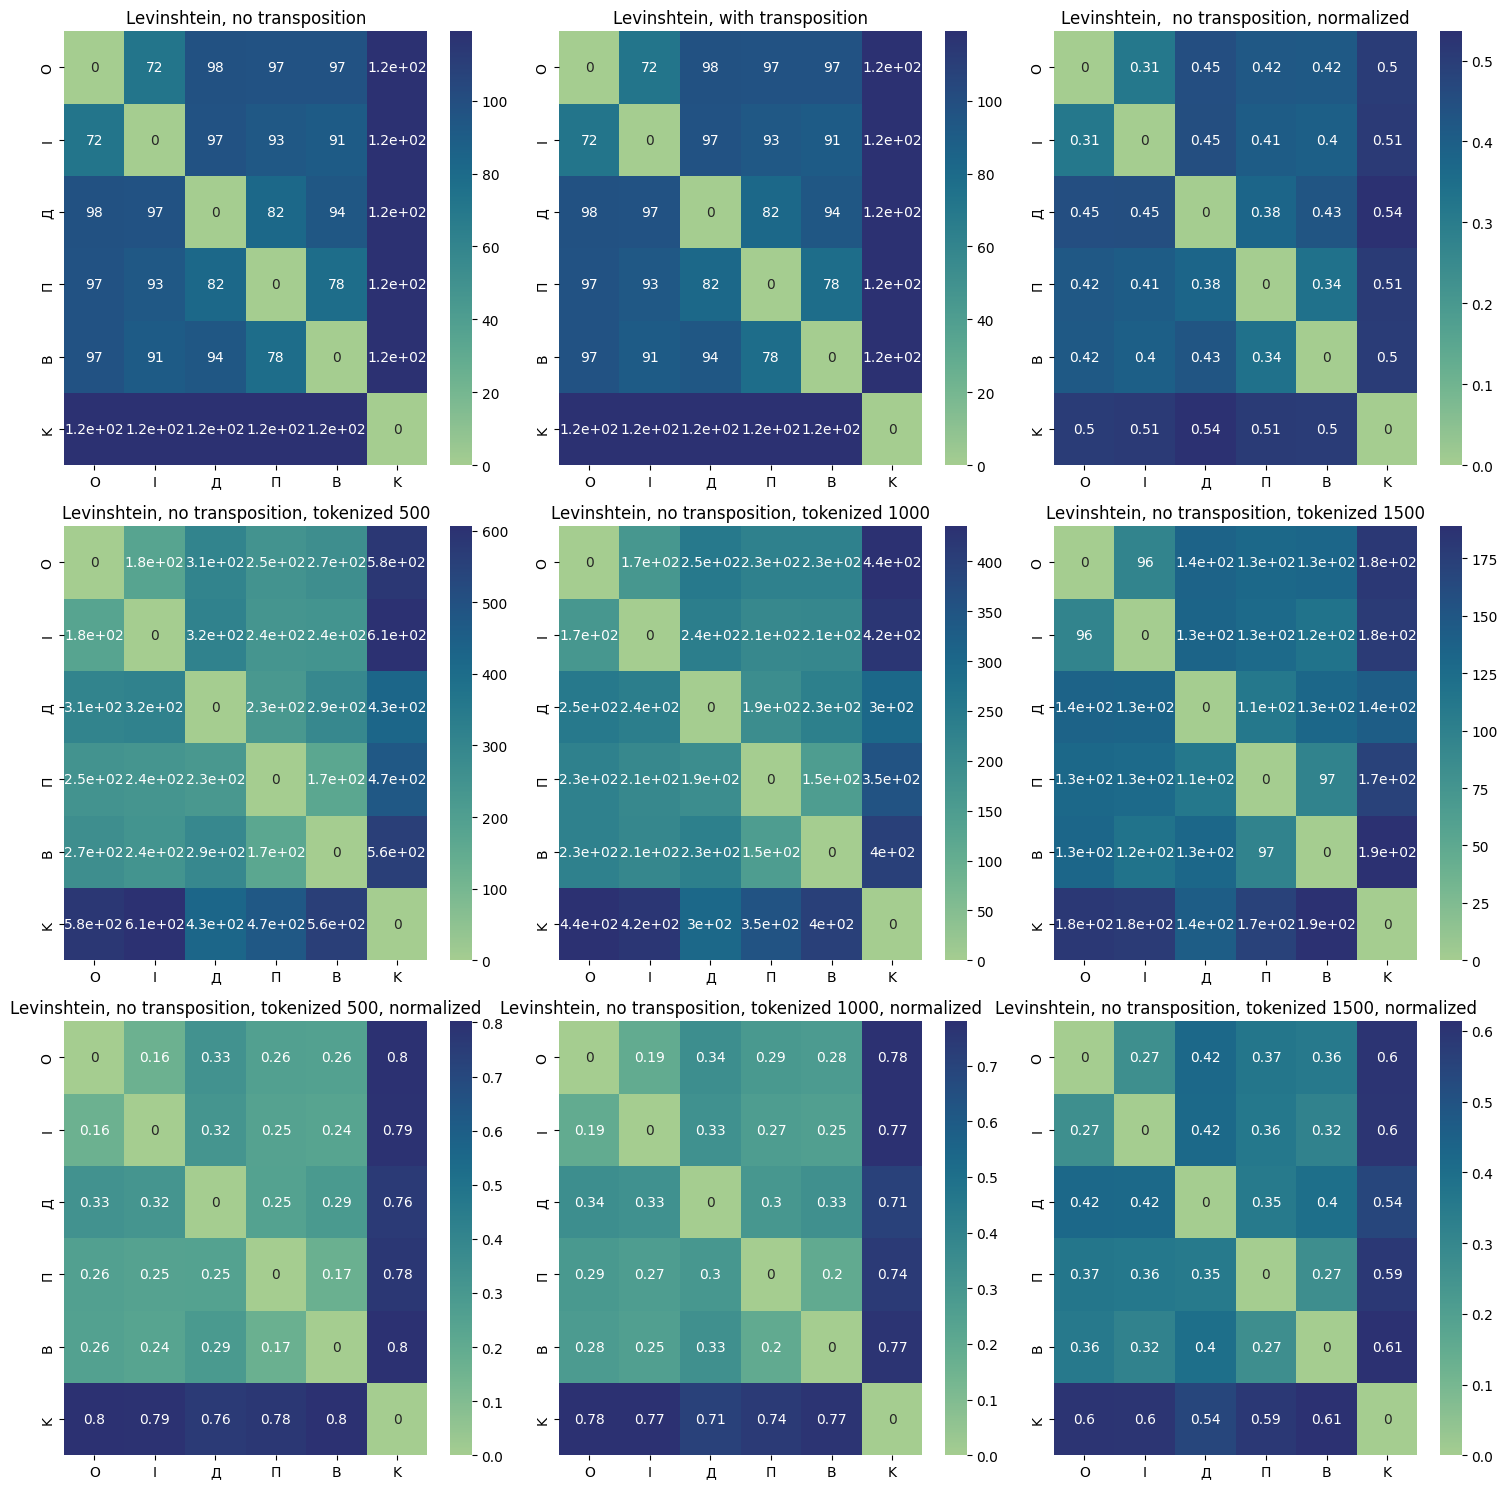

In [119]:
data = get_metrics_matrices(
    [dataset['O'], dataset['I'], dataset['Д'], dataset['П'], dataset['В'], dataset['K']],
    [
        lambda x, y: levenshtein_distance_positions(x, y)['distance'],
        lambda x, y: edit_distance(x,y, substitution_cost=1, transpositions=True),
        lambda x, y: levinshtein_distance_norm(x, y),
        lambda x, y: levenshtein_distance_positions(tokenize(x, old_slavonic_vocab500),tokenize(y, old_slavonic_vocab500))['distance'],
        lambda x, y: levenshtein_distance_positions(tokenize(x, old_slavonic_vocab1000),tokenize(y, old_slavonic_vocab1000))['distance'],
        lambda x, y: levenshtein_distance_positions(tokenize(x, old_slavonic_vocab1500),tokenize(y, old_slavonic_vocab1500))['distance'],
        lambda x, y: levinshtein_distance_norm(tokenize(x, old_slavonic_vocab700),tokenize(y, old_slavonic_vocab700)),
        lambda x, y: levinshtein_distance_norm(tokenize(x, old_slavonic_vocab1000),tokenize(y, old_slavonic_vocab1000)),
        lambda x, y: levinshtein_distance_norm(tokenize(x, old_slavonic_vocab1500),tokenize(y, old_slavonic_vocab1500))
    ],
    [
        'Levinshtein, no transposition',
        'Levinshtein, with transposition',
        'Levinshtein,  no transposition, normalized',
        'Levinshtein, no transposition, tokenized 500',
        'Levinshtein, no transposition, tokenized 1000',
        'Levinshtein, no transposition, tokenized 1500',
        'Levinshtein, no transposition, tokenized 500, normalized',
        'Levinshtein, no transposition, tokenized 1000, normalized',
        'Levinshtein, no transposition, tokenized 1500, normalized'
    ],
    axis_labels=['O', 'I', 'Д', 'П', 'В', 'K']
)

### Попарное сравнение текстов

Сначала посмотрим на разбиение по словам

In [78]:
t1, t2 = highlight_changes_slavic(
    dataset['O'],
    dataset['I'],
)
print(dataset['O'])
print()
print(dataset['I'])

['прѣмѫдрость', 'іисоусова', 'сꙑна', 'сирахова', 'Вьсꙗка', 'мѫдрость', 'отъ', 'господа·', 'и', 'съ', 'нимь', 'ѥстъ', 'въ', 'вѣкꙑ·', 'пѣсъка', 'морьскаѥго', 'и', 'каплѧ', 'дъждевьнꙑѩ·', 'дьни', 'вѣка', 'къто', 'ищьтетъ⁘', 'Прѣмѫдрость', 'къто', 'ислѣдитъ·', 'корень', 'прѣмѫдрости', 'комѹ', 'отъкрꙑ', 'сѧ·', 'и', 'раꙁѹмъ', 'ѥѩ', 'къто', 'раꙁѹмѣ⁘', 'Ѥдинъ', 'ѥстъ', 'прѣмѫдръ·', 'и', 'страшьнъ', 'ѕѣло', 'сѣдѧи', 'на', 'престолѣ', 'своѥмь', 'господь·', 'самъ', 'съꙁьдалъ', 'ѭ·', 'нищетою', 'и', 'видѣ', 'ѭ·', 'и', 'пролиꙗ', 'ѭ', 'на', 'вьсѣхъ', 'дѣлѣхъ', 'своихъ·', 'и', 'даровалъ', 'любѧщиимъ', 'ѥго⁘', 'Ꙁачѧло', 'прѣмѫдрости', 'страхъ', 'господьнь·', 'страхъ', 'господьнь', 'слава', 'и', 'похвала·', 'и', 'веселиѥ', 'и', 'вѣньць', 'радости⁘', 'Страхъ', 'господьнь', 'въꙁвеселитъ', 'срьдьце·', 'и', 'дастъ', 'веселиѥ', 'и', 'длъгодьниѥ⁘', 'Боѩщѹѥмѹ', 'сѧ', 'господа', 'благо', 'бѫдетъ', 'на', 'слѣдъкъ·', 'и', 'въ', 'дьнь', 'съконьчаниꙗ', 'своѥго', 'благословленъ', 'бѫдетъ⁘', 'Мъножьство', 'мѫдрости'

In [112]:
print('portions of black tokens: ', get_portion_of_unchanged_tokens(t1), 'and', get_portion_of_unchanged_tokens(t2))

portions of black tokens:  0.08 and 0.08


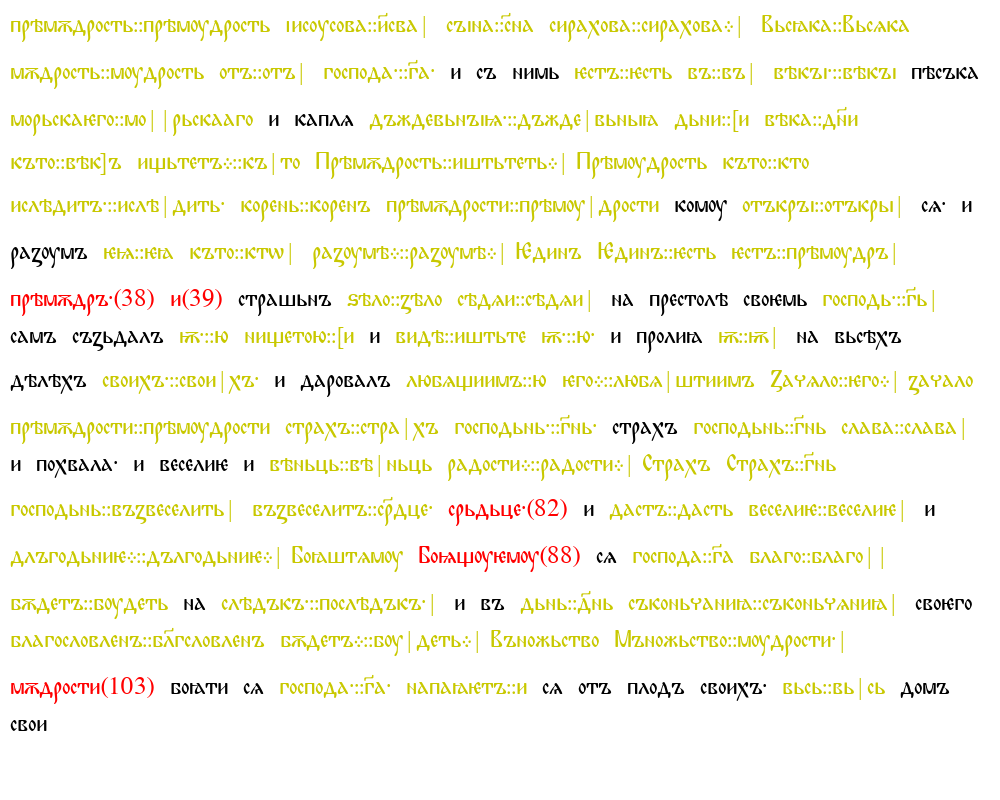

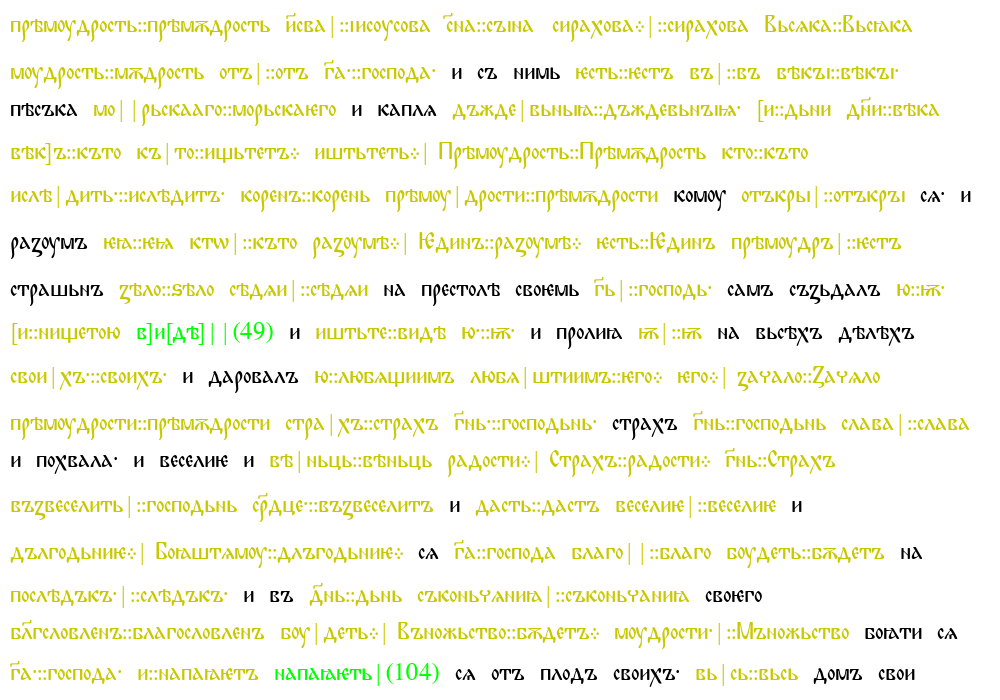

In [105]:
printTextWithColors(t1, canvas_w=1000, canvas_h = 800)
printTextWithColors(t2, canvas_w=1000, canvas_h = 700)

Очень хочется, чтобы слова типа "премудрость" - в общем с разным написанием в одной букве подсвечивались и не влияли так сильно на метрику. То есть с одной стороны подсвечивались, а с другой стороны - не влияли. Может быть это просто немножко разные задачи?

Попробуем с токенами

In [77]:
t1_1500, t2_1500 = highlight_changes_slavic(
    tokenize(dataset['O'], old_slavonic_vocab1500),
    tokenize(dataset['I'], old_slavonic_vocab1500)
)
print(tokenize(dataset['O'], old_slavonic_vocab1500))
print()
print(tokenize(dataset['I'], old_slavonic_vocab1500))

['прѣмѫдрость', 'іисоусова', 'сꙑна', 'сирахова', 'Вьсꙗка', 'мѫдрость', 'отъ', 'госпо', '##да·', 'и', 'съ', 'нимь', 'ѥстъ', 'въ', 'вѣкꙑ·', 'пѣсъка', 'м', '##о', '##рьскаѥг', '##о', 'и', 'каплѧ', 'дъждевьнꙑѩ·', 'дьни', 'вѣка', 'кът', '##о', 'ищьтетъ⁘', 'Прѣмѫдр', '##о', '##сть', 'кът', '##о', 'ислѣдитъ·', 'к', '##о', '##рень', 'прѣмѫдрости', 'к', '##о', '##мѹ', 'отъкрꙑ', 'сѧ·', 'и', 'раꙁѹмъ', 'ѥѩ', 'кът', '##о', 'раꙁѹмѣ⁘', 'Ѥдинъ', 'ѥстъ', 'прѣмѫдръ·', 'и', 'страшьнъ', 'ѕѣл', '##о', 'сѣдѧи', 'на', 'прест', '##о', '##лѣ', 'св', '##о', '##ѥмь', 'госпо', '##дь·', 'самъ', 'съꙁьдалъ', 'ѭ·', 'нищет', '##о', '##ю', 'и', 'видѣ', 'ѭ·', 'и', 'пр', '##о', '##лиꙗ', 'ѭ', 'на', 'вьсѣхъ', 'дѣлѣхъ', 'св', '##о', '##ихъ·', 'и', 'дар', '##о', '##валъ', 'любѧщиимъ', 'ѥг', '##о', '##⁘', 'Ꙁачѧл', '##о', 'прѣмѫдрости', 'страхъ', 'госпо', '##дьнь·', 'страхъ', 'госпо', '##дьнь', 'слава', 'и', 'п', '##о', '##хвала·', 'и', 'веселиѥ', 'и', 'вѣньць', 'рад', '##о', '##сти⁘', 'Страхъ', 'госпо', '##дьнь', 'въꙁвеселитъ

In [113]:
print('portions of black tokens: ', get_portion_of_unchanged_tokens(t1_1500), 'and', get_portion_of_unchanged_tokens(t1_1500))

portions of black tokens:  0.11 and 0.11


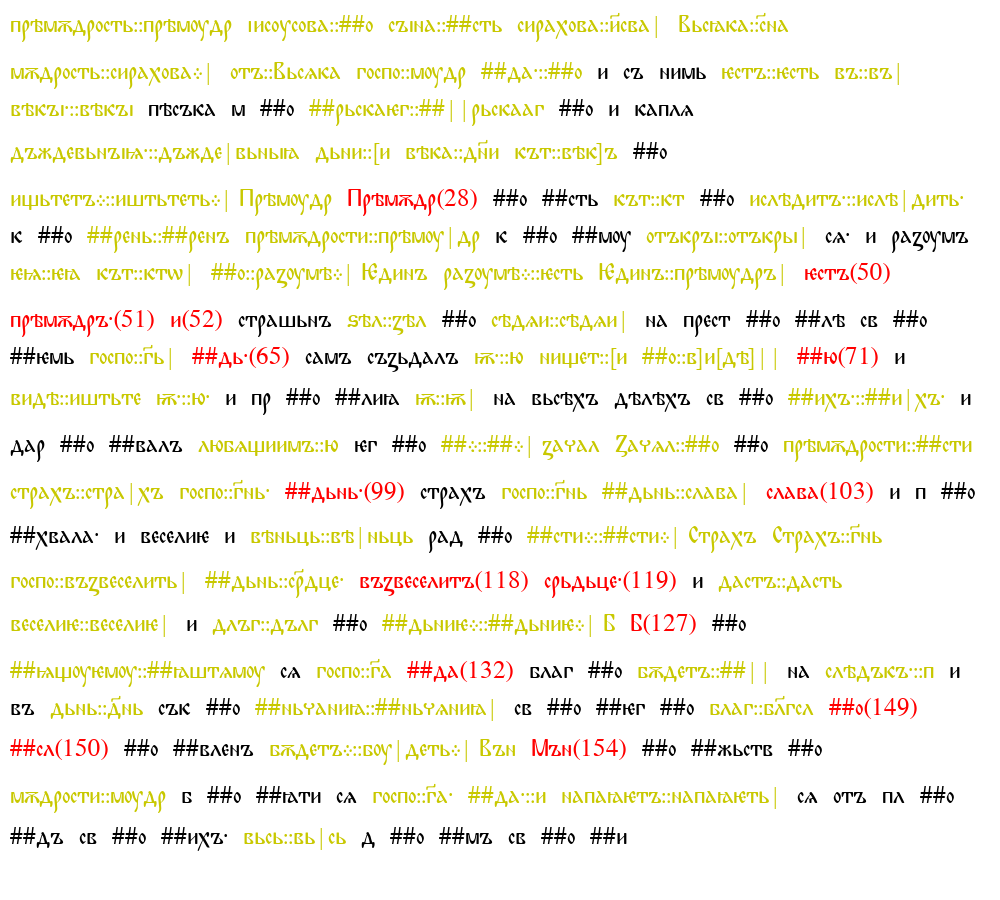

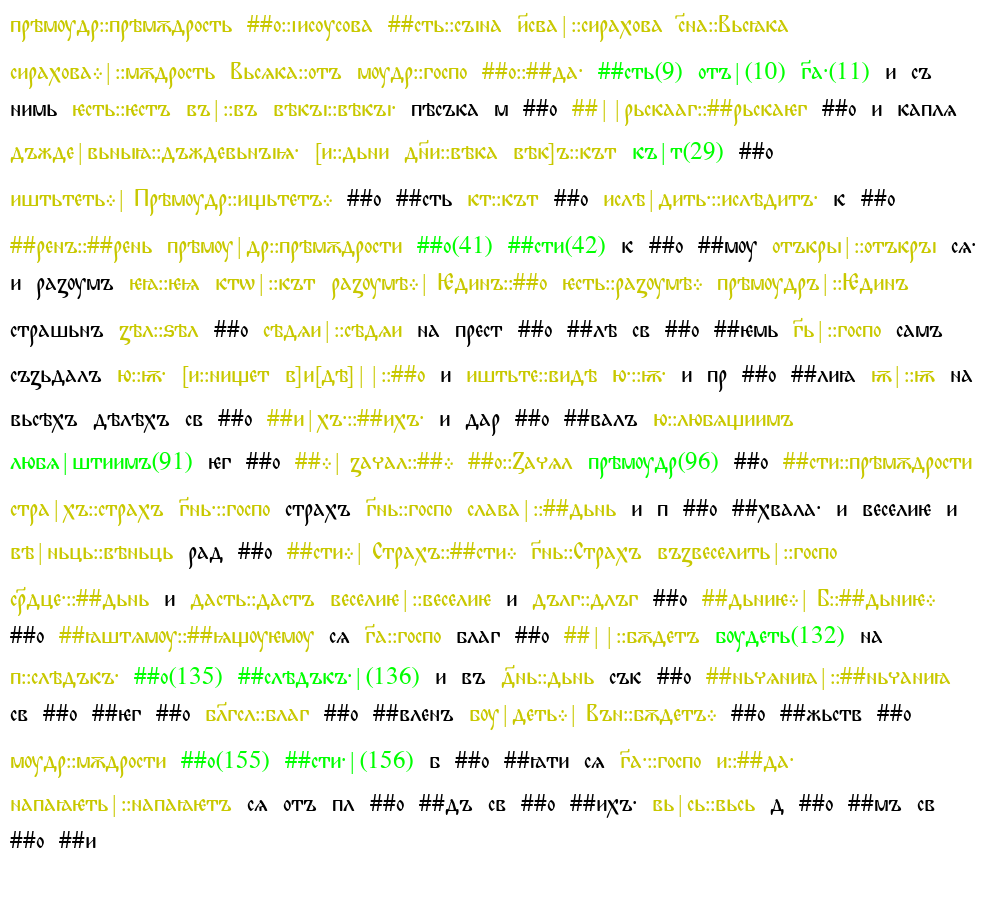

In [103]:
printTextWithColors(t1_1500, canvas_w=1000, canvas_h = 900)
printTextWithColors(t2_1500, canvas_w=1000, canvas_h = 900)

Ну как-то довольно плохо справился 1500. Корни не выделил, и начал добавлять странные замены. Хотя... Вот тут же - у песка МОрскогО. То есть да, не корень, но начало слова он теперь нашел. Кстати странно он разбивает Премудрость. В одном месте ок, а в другом - нет. Почему так? Потому что токенами слово разбиваются от начала слова до максимального конца, и в одном случае это токен - с заглавной буквой, а в другом - нет. Тот, который не с заглавной - это и есть все слово [такой такоен лежит]

In [85]:
t1_1000, t2_1000 = highlight_changes_slavic(
    tokenize(dataset['O'], old_slavonic_vocab1000),
    tokenize(dataset['I'], old_slavonic_vocab1000)
)
print(tokenize(dataset['O'], old_slavonic_vocab1000))
print()
print(tokenize(dataset['I'], old_slavonic_vocab1000))

['прѣмѫдр', '##о', '##с', '##т', '##ь', 'іис', '##о', '##ус', '##о', '##в', '##а', 'сꙑн', '##а', 'с', '##и', '##р', '##а', '##х', '##о', '##в', '##а', 'Вьсꙗк', '##а', 'мѫдр', '##о', '##с', '##т', '##ь', 'о', '##т', '##ъ', 'г', '##о', '##с', '##п', '##о', '##д', '##а', '##·', 'и', 'с', '##ъ', 'н', '##и', '##м', '##ь', 'ѥс', '##т', '##ъ', 'в', '##ъ', 'вѣкꙑ·', 'п', '##ѣ', '##с', '##ъ', '##к', '##а', 'м', '##о', '##р', '##ь', '##с', '##к', '##а', '##ѥг', '##о', 'и', 'к', '##а', '##п', '##л', '##ѧ', 'дъждевьнꙑѩ·', 'дьни', 'вѣк', '##а', 'к', '##ъ', '##т', '##о', 'ищь', '##т', '##е', '##т', '##ъ', '##⁘', 'Прѣмѫдр', '##о', '##с', '##т', '##ь', 'к', '##ъ', '##т', '##о', 'и', '##слѣд', '##и', '##т', '##ъ', '##·', 'к', '##о', '##рень', 'прѣмѫдр', '##о', '##с', '##т', '##и', 'к', '##о', '##мѹ', 'о', '##т', '##ъкрꙑ', 'с', '##ѧ', '##·', 'и', 'р', '##а', '##ꙁѹмъ', 'ѥѩ', 'к', '##ъ', '##т', '##о', 'р', '##а', '##ꙁѹмѣ⁘', 'Ѥдинъ', 'ѥс', '##т', '##ъ', 'прѣмѫдр', '##ъ', '##·', 'и', 'с', '##т', '##р', '##а'

In [114]:
print('portions of black tokens: ', get_portion_of_unchanged_tokens(t1_1000), 'and', get_portion_of_unchanged_tokens(t2_1000))

portions of black tokens:  0.19 and 0.21


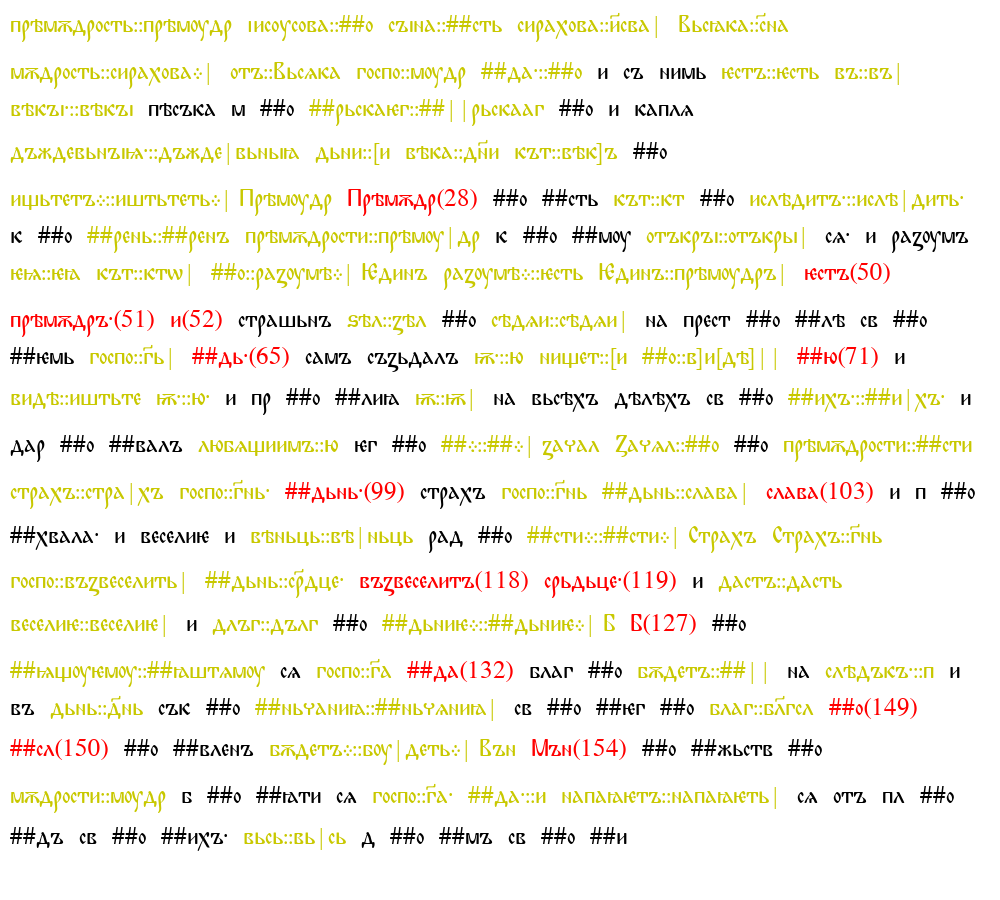

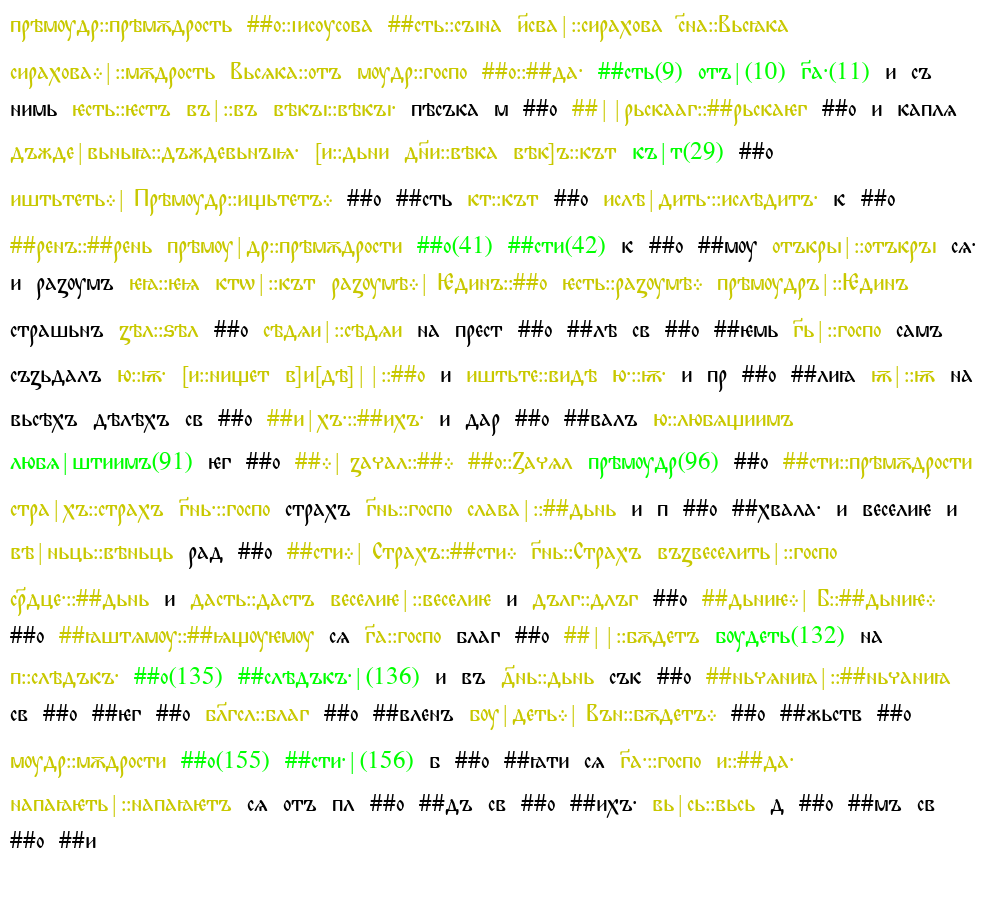

In [87]:
printTextWithColors(t1_1500, canvas_w=1000, canvas_h = 900)
printTextWithColors(t2_1500, canvas_w=1000, canvas_h = 900)

Смотрю на количество черных. Да, их прибавляется. Надо найти пример, который был желным, а стал черным

In [120]:
t1_700, t2_700 = highlight_changes_slavic(
    tokenize(dataset['O'], old_slavonic_vocab700),
    tokenize(dataset['I'], old_slavonic_vocab700)
)
print(tokenize(dataset['O'], old_slavonic_vocab700))
print()
print(tokenize(dataset['I'], old_slavonic_vocab700))

['прѣмѫдр', '##о', '##с', '##т', '##ь', 'і', '##и', '##с', '##о', '##у', '##с', '##о', '##в', '##а', 'с', '##ꙑ', '##н', '##а', 'с', '##и', '##р', '##а', '##х', '##о', '##в', '##а', 'В', '##ь', '##с', '##ꙗ', '##к', '##а', 'мѫдр', '##о', '##с', '##т', '##ь', 'о', '##т', '##ъ', 'г', '##о', '##с', '##п', '##о', '##д', '##а', '##·', 'и', 'с', '##ъ', 'н', '##и', '##м', '##ь', 'ѥ', '##с', '##т', '##ъ', 'в', '##ъ', 'вѣкꙑ', '##·', 'п', '##ѣ', '##с', '##ъ', '##к', '##а', 'м', '##о', '##р', '##ь', '##с', '##к', '##а', '##ѥг', '##о', 'и', 'к', '##а', '##п', '##л', '##ѧ', 'дъждевьнꙑѩ·', 'д', '##ь', '##н', '##и', 'в', '##ѣ', '##к', '##а', 'к', '##ъ', '##т', '##о', 'и', '##щ', '##ь', '##т', '##е', '##т', '##ъ', '##⁘', 'Прѣмѫдр', '##о', '##с', '##т', '##ь', 'к', '##ъ', '##т', '##о', 'и', '##с', '##л', '##ѣ', '##д', '##и', '##т', '##ъ', '##·', 'к', '##о', '##р', '##е', '##н', '##ь', 'прѣмѫдр', '##о', '##с', '##т', '##и', 'к', '##о', '##мѹ', 'о', '##т', '##ъ', '##к', '##р', '##ꙑ', 'с', '##ѧ', '##·', 'и'

In [121]:
print('portions of black tokens: ', get_portion_of_unchanged_tokens(t1_500), 'and', get_portion_of_unchanged_tokens(t2_500))

portions of black tokens:  0.33 and 0.3


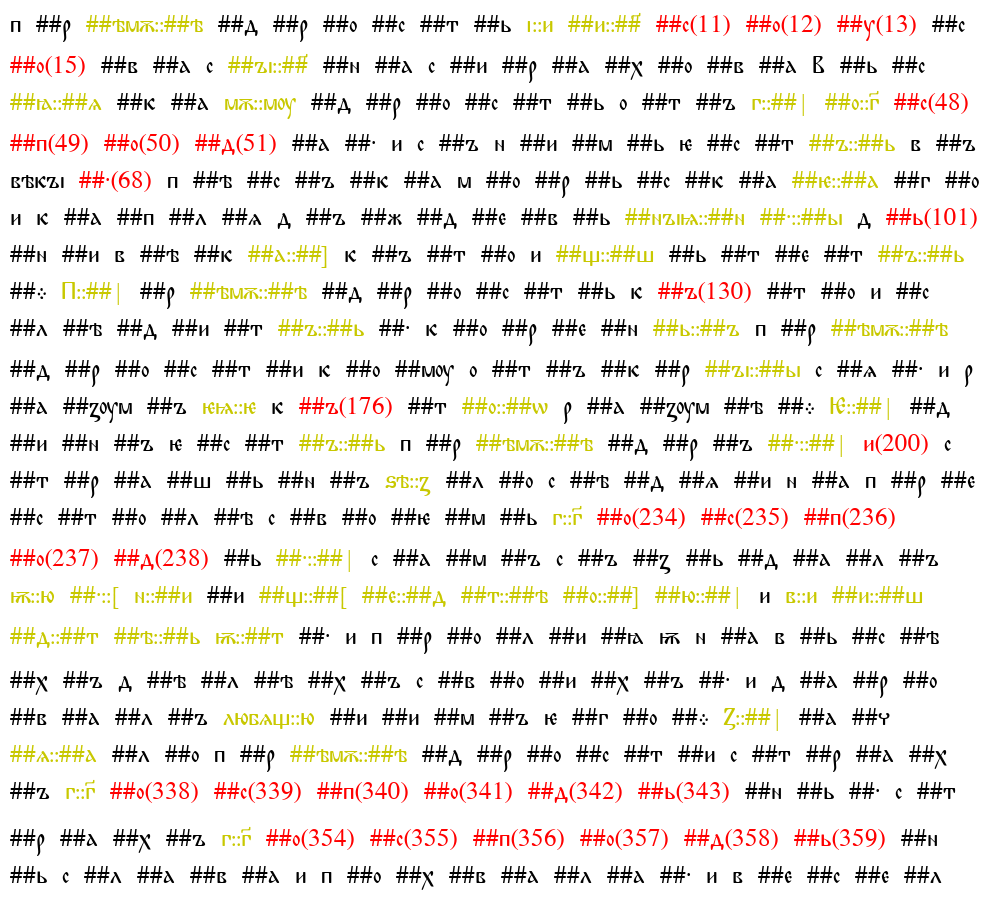

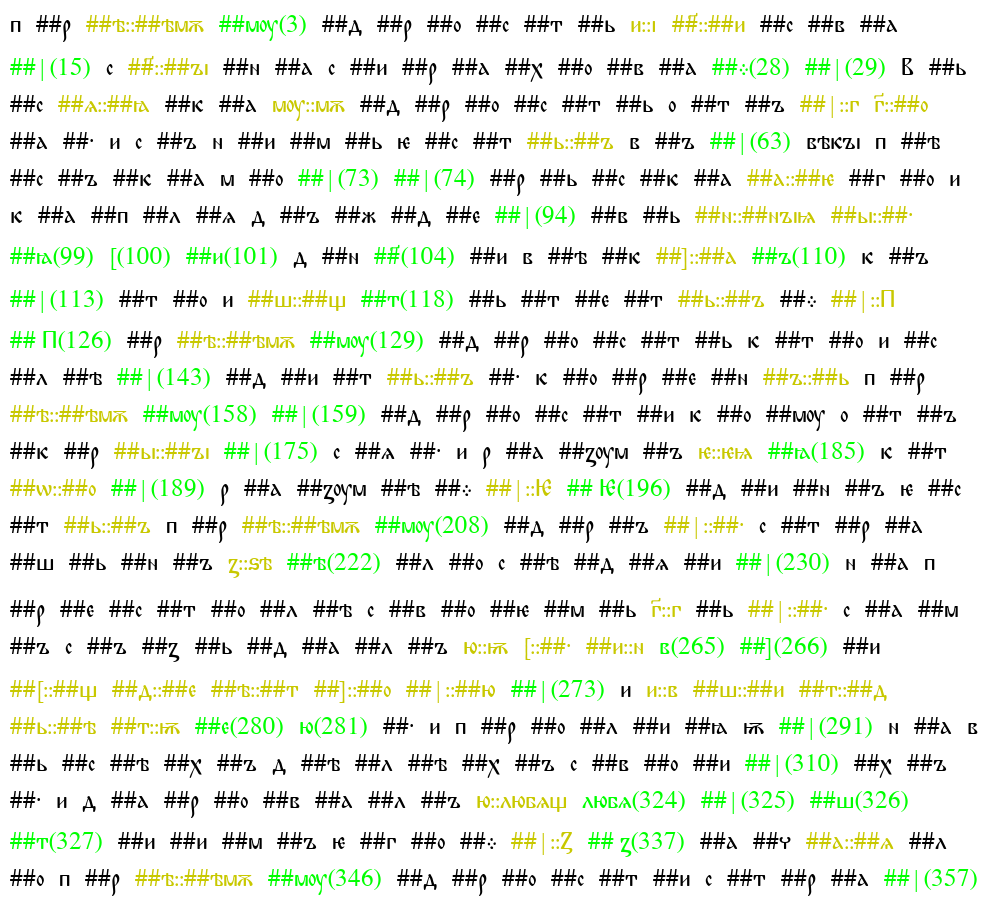

In [122]:
printTextWithColors(t1_500, canvas_w=1000, canvas_h = 900)
printTextWithColors(t2_500, canvas_w=1000, canvas_h = 900)

Вижу, что совпадение почит только по букве. Это неинтересно. 

In [123]:
old_slavonic_vocab850 = fit_tokenizer(
    [dataset['O'], dataset['I'], dataset['Д'], dataset['П'], dataset['В'], dataset['K']],
    850
)

vocab size:  850


In [124]:
t1_850, t2_850 = highlight_changes_slavic(
    tokenize(dataset['O'], old_slavonic_vocab850),
    tokenize(dataset['I'], old_slavonic_vocab850)
)
print(tokenize(dataset['O'], old_slavonic_vocab850))
print()
print(tokenize(dataset['I'], old_slavonic_vocab850))

['прѣмѫдр', '##о', '##с', '##т', '##ь', 'і', '##и', '##с', '##о', '##ус', '##о', '##в', '##а', 'сꙑн', '##а', 'с', '##и', '##р', '##а', '##х', '##о', '##в', '##а', 'В', '##ь', '##с', '##ꙗ', '##к', '##а', 'мѫдр', '##о', '##с', '##т', '##ь', 'о', '##т', '##ъ', 'г', '##о', '##с', '##п', '##о', '##д', '##а', '##·', 'и', 'с', '##ъ', 'н', '##и', '##м', '##ь', 'ѥс', '##т', '##ъ', 'в', '##ъ', 'вѣкꙑ', '##·', 'п', '##ѣ', '##с', '##ъ', '##к', '##а', 'м', '##о', '##р', '##ь', '##с', '##к', '##а', '##ѥг', '##о', 'и', 'к', '##а', '##п', '##л', '##ѧ', 'дъждевьнꙑѩ·', 'д', '##ь', '##н', '##и', 'в', '##ѣ', '##к', '##а', 'к', '##ъ', '##т', '##о', 'и', '##щ', '##ь', '##т', '##е', '##т', '##ъ', '##⁘', 'Прѣмѫдр', '##о', '##с', '##т', '##ь', 'к', '##ъ', '##т', '##о', 'и', '##с', '##л', '##ѣ', '##д', '##и', '##т', '##ъ', '##·', 'к', '##о', '##р', '##е', '##н', '##ь', 'прѣмѫдр', '##о', '##с', '##т', '##и', 'к', '##о', '##мѹ', 'о', '##т', '##ъкрꙑ', 'с', '##ѧ', '##·', 'и', 'р', '##а', '##ꙁѹмъ', 'ѥѩ', 'к', '##ъ', 

In [125]:
print('portions of black tokens: ', get_portion_of_unchanged_tokens(t1_850), 'and', get_portion_of_unchanged_tokens(t2_850))

portions of black tokens:  0.2 and 0.24


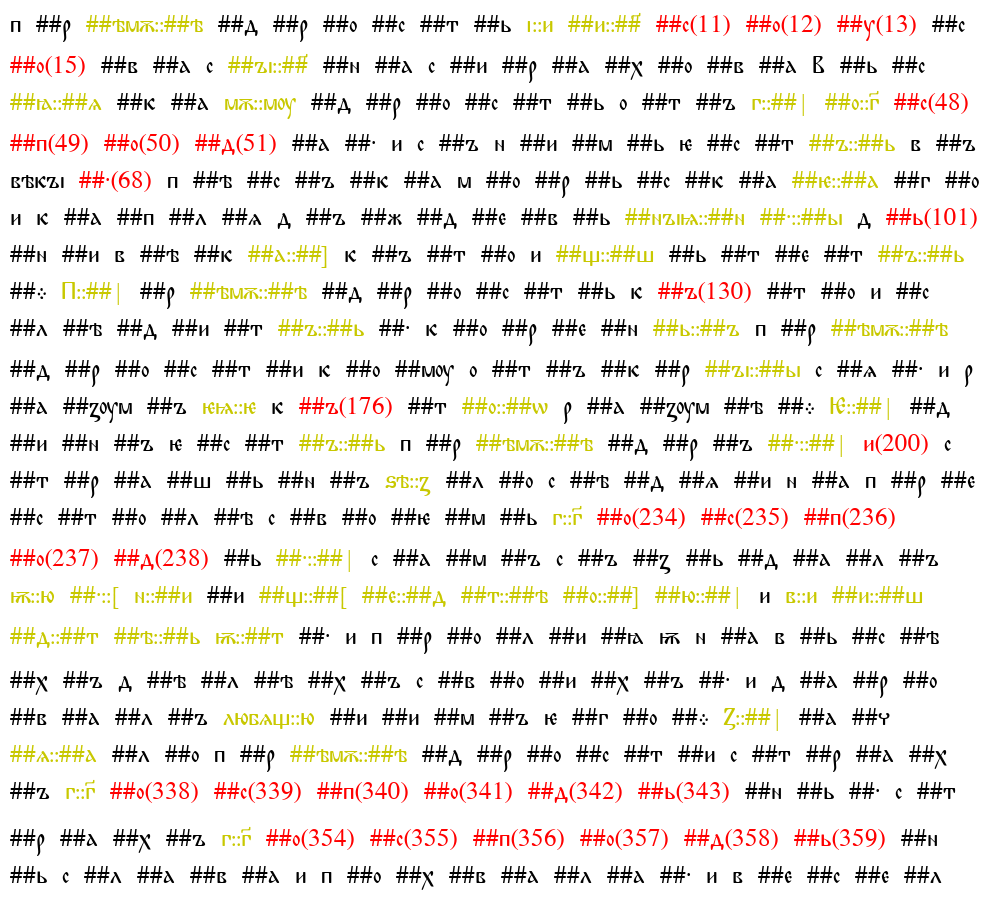

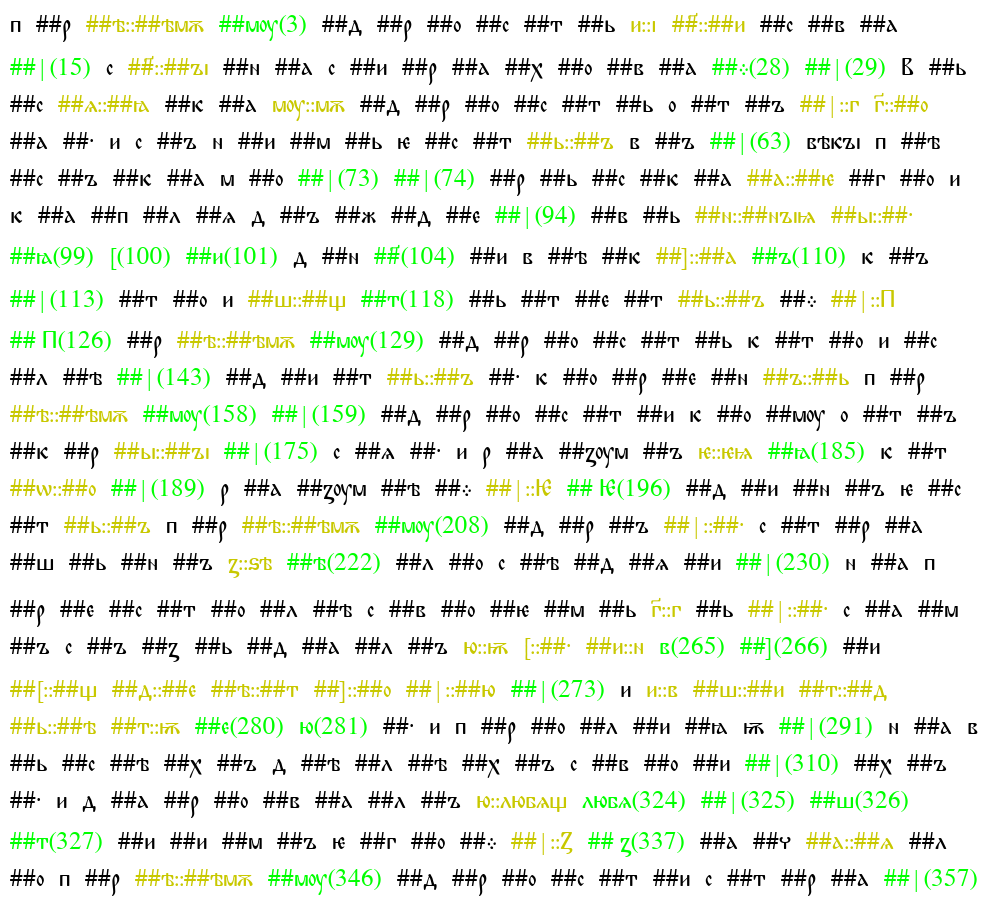

In [126]:
printTextWithColors(t1_500, canvas_w=1000, canvas_h = 900)
printTextWithColors(t2_500, canvas_w=1000, canvas_h = 900)

Видим, что не очень помогает. Значит надо на всем наборе слов обучить словарь и попробовать так с ним поработать

In [129]:
dataset_big = superdict.copy()

for key in dataset_big.keys():
    dataset_big[key] = ''.join(dataset_big[key][1:])  # пропускаем первую строчку
    dataset_big[key] = dataset_big[key].split(' ')
    
print(len(dataset_big['O']))

5534


In [139]:
old_slavonic_vocab_big = fit_tokenizer(
    [dataset_big['O'], dataset_big['I'], dataset_big['Д'], dataset_big['П'], dataset_big['В'], dataset_big['K']],
    25000
)

vocab size:  25000


max vocab size exceeded
vocab size:  33451

In [141]:
t1_big, t2_big = highlight_changes_slavic(
    tokenize(dataset['O'], old_slavonic_vocab_big),
    tokenize(dataset['I'], old_slavonic_vocab_big)
)
print(tokenize(dataset['O'], old_slavonic_vocab_big))
print()
print(tokenize(dataset['I'], old_slavonic_vocab_big))

['прѣмѫдрость', 'іисоусова', 'с', '##ꙑ', '##н', '##а', 'с', '##и', '##р', '##а', '##х', '##о', '##в', '##а', 'Вьсꙗка', 'мѫдрость', 'отъ', 'господа·', 'и', 'с', '##ъ', 'н', '##и', '##мь', 'ѥстъ', 'въ', 'вѣкꙑ·', 'пѣсъка', 'морьскаѥго', 'и', 'к', '##а', '##п', '##л', '##ѧ', 'дъждевьнꙑѩ·', 'дьни', 'в', '##ѣ', '##к', '##а', 'къто', 'ищьтетъ⁘', 'Прѣмѫдрость', 'къто', 'и', '##с', '##л', '##ѣ', '##д', '##и', '##т', '##ъ', '##·', 'к', '##о', '##р', '##е', '##нь', 'прѣмѫдрости', 'комѹ', 'отъ', '##к', '##р', '##ꙑ', 'сѧ', '##·', 'и', 'раꙁѹм', '##ъ', 'ѥѩ', 'къто', 'раꙁѹмѣ⁘', 'Ѥдинъ', 'ѥстъ', 'прѣмѫдръ·', 'и', 'страшьнъ', 'ѕѣло', 'с', '##ѣ', '##д', '##ѧ', '##и', 'на', 'пр', '##е', '##ст', '##о', '##л', '##ѣ', 'своѥмь', 'господь·', 'с', '##а', '##м', '##ъ', 'съꙁьдалъ', 'ѭ·', 'нищетою', 'и', 'в', '##и', '##д', '##ѣ', 'ѭ·', 'и', 'пр', '##о', '##л', '##и', '##ꙗ', 'ѭ', 'на', 'вьсѣхъ', 'дѣлѣхъ', 'с', '##в', '##о', '##и', '##хъ', '##·', 'и', 'да', '##р', '##о', '##в', '##а', '##л', '##ъ', 'любѧщиимъ', 'ѥго

In [142]:
print('portions of black tokens: ', get_portion_of_unchanged_tokens(t1_big), 'and', get_portion_of_unchanged_tokens(t2_big))

portions of black tokens:  0.12 and 0.12


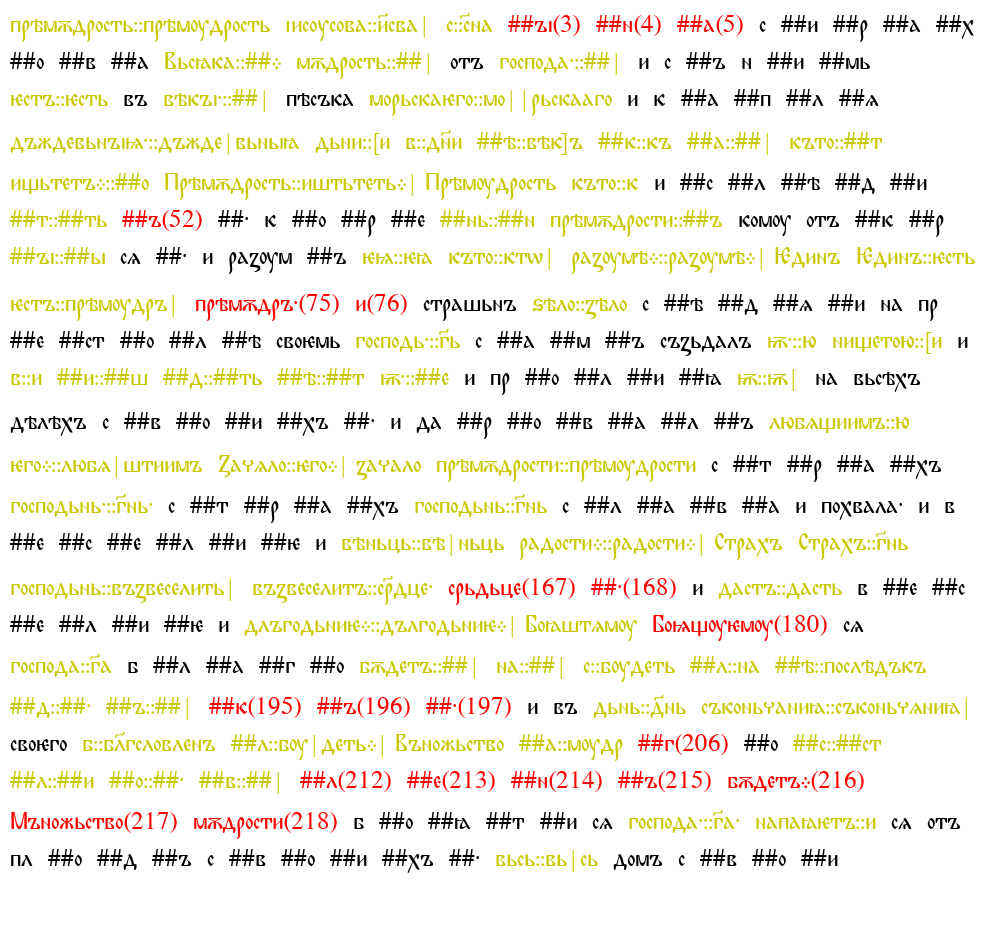

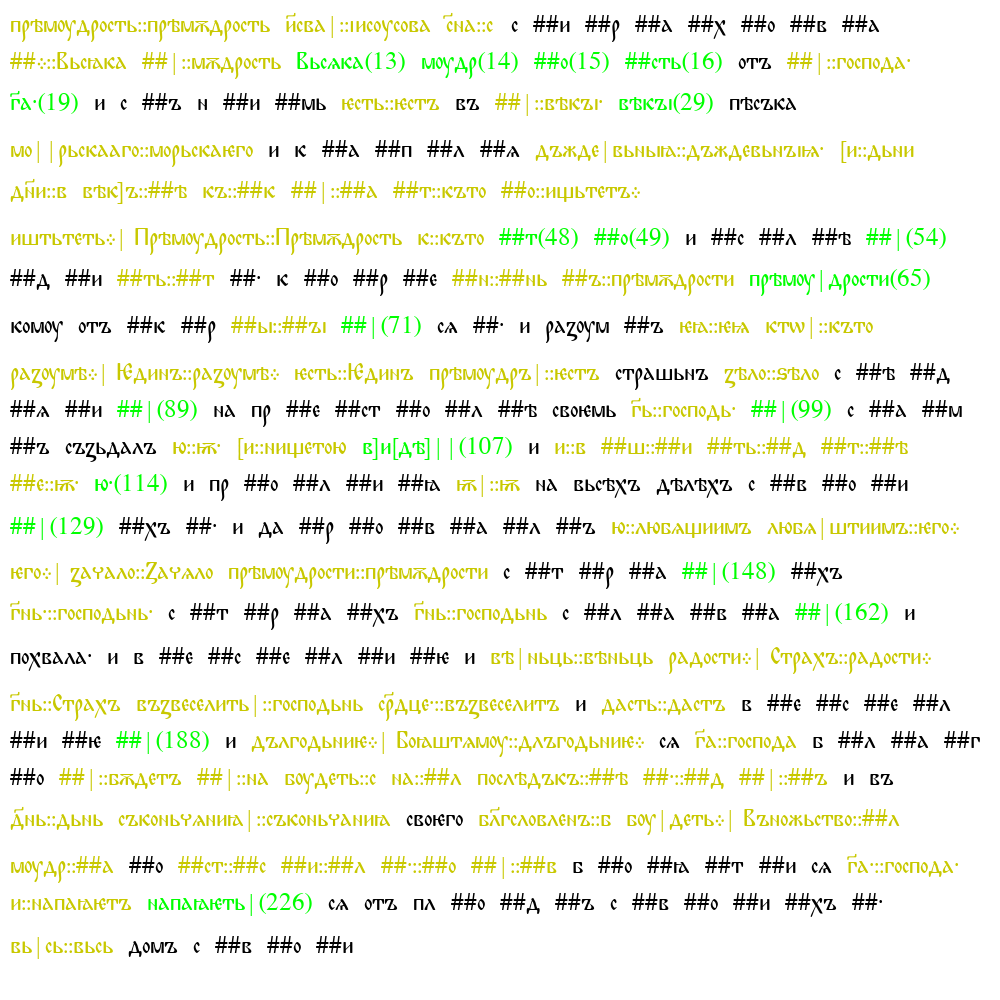

In [156]:
printTextWithColors(t1_big, canvas_w=1000, canvas_h = 950)
printTextWithColors(t2_big, canvas_w=1000, canvas_h = 1000)

Хочется побольше слов черными

In [157]:
old_slavonic_vocab_28k = fit_tokenizer(
    [dataset_big['O'], dataset_big['I'], dataset_big['Д'], dataset_big['П'], dataset_big['В'], dataset_big['K']],
    28000
)

vocab size:  28000


In [158]:
t1_28k, t2_28k = highlight_changes_slavic(
    tokenize(dataset['O'], old_slavonic_vocab_28k),
    tokenize(dataset['I'], old_slavonic_vocab_28k)
)
print(tokenize(dataset['O'], old_slavonic_vocab_28k))
print()
print(tokenize(dataset['I'], old_slavonic_vocab_28k))

['прѣмѫдрость', 'іисоусова', 'сꙑна', 'с', '##и', '##р', '##а', '##х', '##о', '##в', '##а', 'Вьсꙗка', 'мѫдрость', 'отъ', 'господа·', 'и', 'с', '##ъ', 'н', '##и', '##мь', 'ѥстъ', 'въ', 'вѣкꙑ·', 'пѣсъка', 'морьскаѥго', 'и', 'каплѧ', 'дъждевьнꙑѩ·', 'дьни', 'вѣка', 'къто', 'ищьтетъ⁘', 'Прѣмѫдрость', 'къто', 'ислѣдитъ·', 'корень', 'прѣмѫдрости', 'комѹ', 'отъкрꙑ', 'сѧ', '##·', 'и', 'раꙁѹм', '##ъ', 'ѥѩ', 'къто', 'раꙁѹмѣ⁘', 'Ѥдинъ', 'ѥстъ', 'прѣмѫдръ·', 'и', 'страшьнъ', 'ѕѣло', 'сѣдѧи', 'на', 'пр', '##ес', '##т', '##о', '##л', '##ѣ', 'своѥмь', 'господь·', 'с', '##а', '##мъ', 'съꙁьдалъ', 'ѭ·', 'нищетою', 'и', 'в', '##и', '##д', '##ѣ', 'ѭ·', 'и', 'пр', '##о', '##л', '##и', '##ꙗ', 'ѭ', 'на', 'вьсѣхъ', 'дѣлѣхъ', 'с', '##в', '##о', '##и', '##хъ', '##·', 'и', 'да', '##р', '##о', '##в', '##а', '##л', '##ъ', 'любѧщиимъ', 'ѥго⁘', 'Ꙁачѧло', 'прѣмѫдрости', 'с', '##т', '##р', '##а', '##хъ', 'господьнь·', 'с', '##т', '##р', '##а', '##хъ', 'господьнь', 'с', '##л', '##а', '##в', '##а', 'и', 'похвала·', 'и', '

In [159]:
print('portions of black tokens: ', get_portion_of_unchanged_tokens(t1_28k), 'and', get_portion_of_unchanged_tokens(t2_28k))

portions of black tokens:  0.12 and 0.1


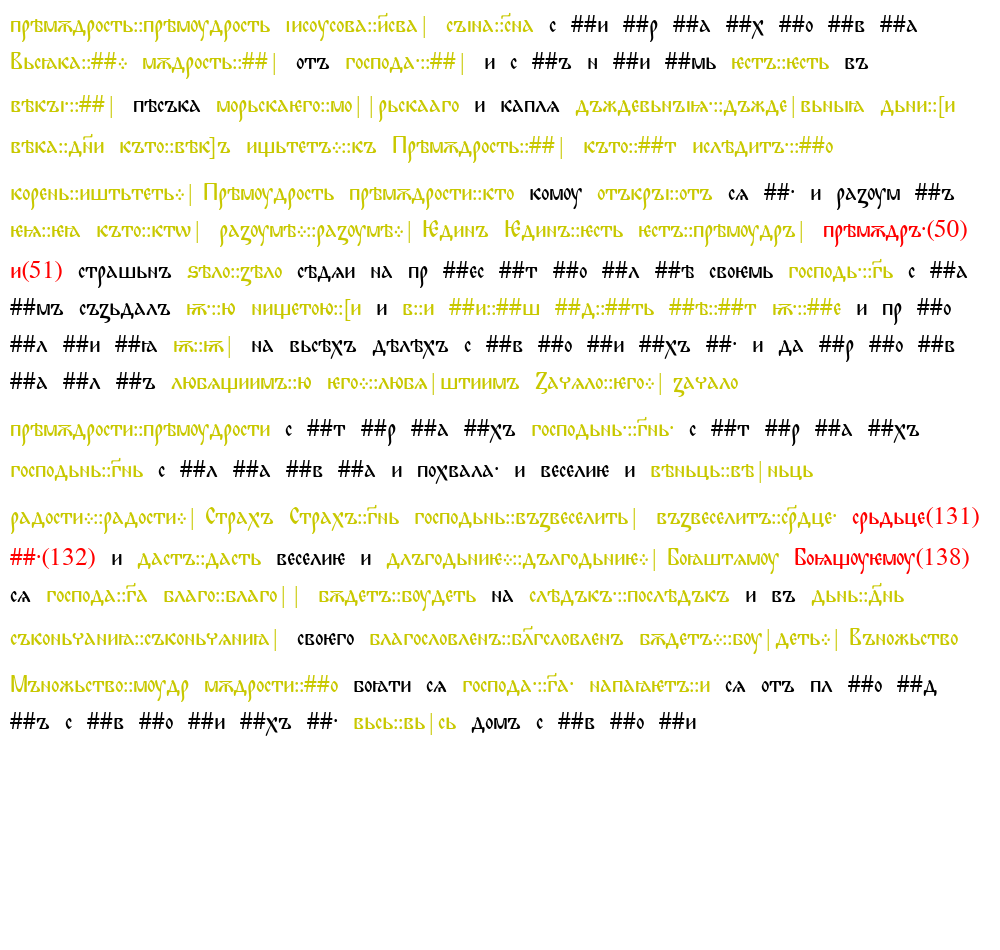

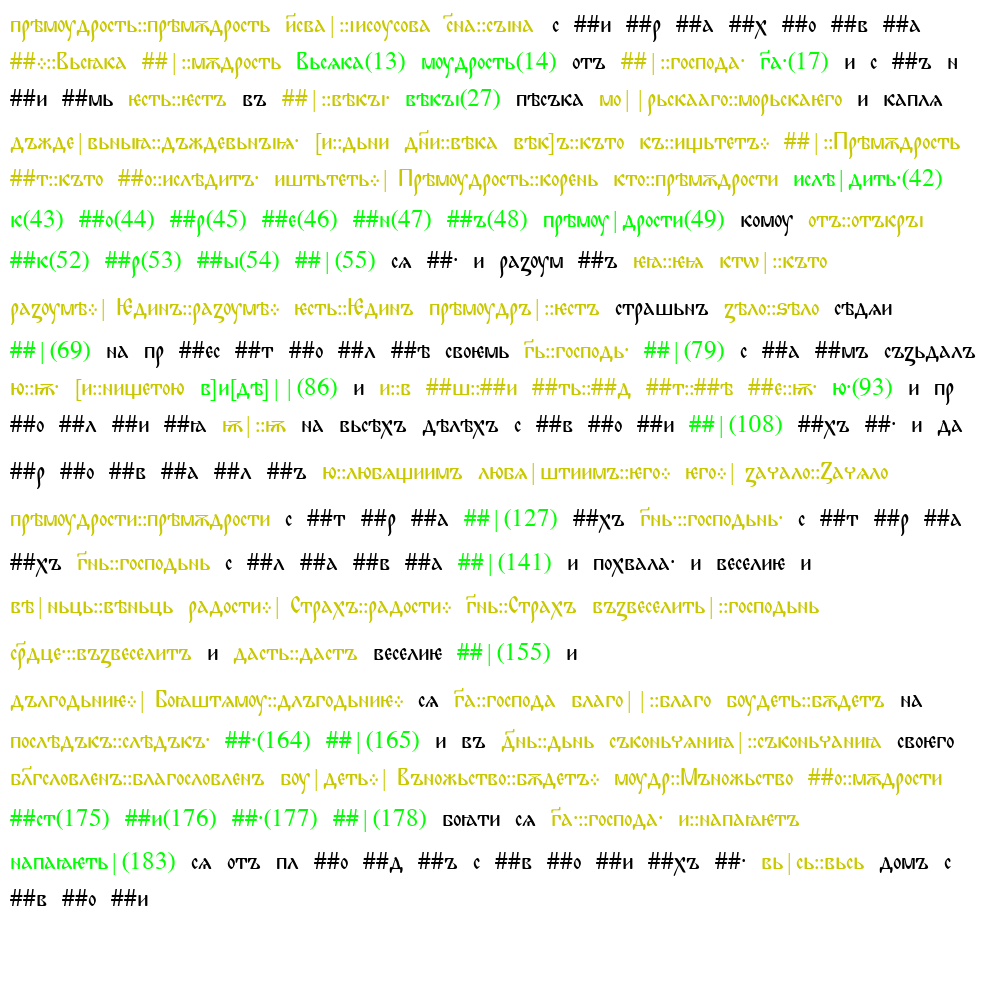

In [160]:
printTextWithColors(t1_28k, canvas_w=1000, canvas_h = 950)
printTextWithColors(t2_28k, canvas_w=1000, canvas_h = 1000)

Подытог: пока не удается извлекать смысловые корни и разбивать слова так, чтобы корни сходились, а суффиксы нет. Пока целиком либо совпадение, либо нет